# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays

from implicit.als import AlternatingLeastSquares

from scipy.sparse import coo_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

import threadpoolctl
threadpoolctl.threadpool_limits(1, "blas")

import sys
sys.path.append('../scripts')

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

from data_preprocessing import date_conversion
from data_preprocessing import get_memory_usage
from data_preprocessing import optimize_numeric_columns
from data_preprocessing import ilif

# Постановка задачи

**Бизнес-постановка задачи:**  
Разработать рекомендательную систему, с целью повысить прибыль от допродаж в интернет-магазине, на 20 %

**Техническая задача:**  
Разместить на главное странице сайта рекомендации товаров по идентификатору пользователя в трех местах.

* Создать сервис, выдающий рекомендации по идентификатору пользователя.
* Обёрнуть сервис в Docker.
* Написать документацию, описание функциональности.
* Сделать презентацию для менеджера с описанием принципов работы.

**Техническая метрика оценки качества:**  
Precision@3

## Получение данных

### Характеристики данных

**events** — датасет с событиями. Колонки:
* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

**category_tree** — файл с деревом категорий (можно восстановить дерево).
* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

**item_properties** — файл с свойствами товаров.
* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство, кажется, они все, кроме категории, захешированы
* value — значение свойства

### Загрузка и знакомство с данными

In [2]:
DATA_PATCH = '../data/'

In [3]:
events            = pd.read_csv(DATA_PATCH + 'events.csv')
category_tree     = pd.read_csv(DATA_PATCH + 'category_tree.csv')
item_properties_1 = pd.read_csv(DATA_PATCH + 'item_properties_part1.csv')
item_properties_2 = pd.read_csv(DATA_PATCH + 'item_properties_part2.csv')

# Объеденим свойства товара в один датасет
item_properties = pd.concat([item_properties_1, item_properties_2], ignore_index=True)

In [4]:
display(events.head(3))
display(category_tree.head(3))
display(item_properties.head(3))

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566


# Исследование данных

## Описание структуры данных

In [5]:
print(f'events: {events.shape}')
print(f'category_tree: {category_tree.shape}')
print(f'item_properties: {item_properties.shape}')

events: (2756101, 5)
category_tree: (1669, 2)
item_properties: (20275902, 4)


Наборы данных с событиями и свойствами товаров достаточно большие (имеют почти 3 и 20 млн. записей соответсвенно). Посмотрим на строковые признаки, какое количество уникальных значений они содержат.

In [6]:
print(f'Типы событий: {events["event"].unique()}')
print(f'Количество уникальных признаков товара: {item_properties["property"].nunique()}')

Типы событий: ['view' 'addtocart' 'transaction']
Количество уникальных признаков товара: 1104


Поскольку разных типов всего три и уникальных признаков товара всего около 1000 из 20 млн., приведем эти признаки к категориальному типу, для экономии оперативной памяти и небольшого ускорения обработки данных.

За одно, приведем числовые признаки к наименьшей разрядности int и float.

### Оптимизация данных

Подсчет занимаемой оперативной памяти

In [7]:
events_before           = get_memory_usage(events)
category_tree_before    = get_memory_usage(category_tree)
item_properties_before  = get_memory_usage(item_properties)

print('Объем занимаемой помяти до оптимизации:')
print(f'events\t\t{events_before} Mb')
print(f'category_tree\t{category_tree_before} Mb')
print(f'item_properties {item_properties_before} Mb')

Объем занимаемой помяти до оптимизации:
events		244.9 Mb
category_tree	0.0 Mb
item_properties 2925.5 Mb


Преобразование даты

In [8]:
events          = date_conversion(events, 'timestamp')
item_properties = date_conversion(item_properties, 'timestamp')

Преоразование типов данных, для уменьшения используемой памяти.

In [9]:
events['event'] = events['event'].astype('category')

item_properties['property'] = item_properties['property'].astype('category')

In [10]:
events          = optimize_numeric_columns(events)
item_properties = optimize_numeric_columns(item_properties)

Повторный подсчет занимаемой оперативной памяти

In [11]:
events_after           = get_memory_usage(events)
item_properties_after  = get_memory_usage(item_properties)

events_percent          = (events_after / events_before) * 100
item_properties_percent = (item_properties_after / item_properties_before) * 100

print('Объем занимаемой помяти после оптимизации:')
print(f'events\t\t{events_after} Mb \t(уменьшено на {100 - events_percent.round(1)} %)')
print(f'item_properties {item_properties_after} Mb \t(уменьшено на {100 - item_properties_percent.round(1)} %)')

Объем занимаемой помяти после оптимизации:
events		55.2 Mb 	(уменьшено на 77.5 %)
item_properties 1714.4 Mb 	(уменьшено на 41.4 %)


## Статистический анализ данных

Посмотрим на временной период данных

In [12]:
print(f'Начальная дата: {events["date"].min()}')

print(f'Конечная дата: {events["date"].max()}')

Начальная дата: 2015-05-03 03:00:04.384000
Конечная дата: 2015-09-18 02:59:47.788000


Посмотрим, какой процент продаж обеспечивают топовые товары после 1 июля

In [13]:
before_july = events[(events['date'] <= '2015-07-01') & (events['event'] == 'transaction')]
after_july  = events[(events['date'] > '2015-07-01')  & (events['event'] == 'transaction')]

# Найдите топ-3 товара до 1 июля по числу транзакций
top_items_before_july = before_july['itemid'].value_counts().head(3)

# Выделите транзакции с товарами из топ-3 после 1 июля
transactions_after_july = after_july[after_july['itemid'].isin(top_items_before_july.index)]

# Посчитайте процент продаж, которые обеспечивают эти топ-3 товара после 1 июля
percentage_sales_covered = transactions_after_july.shape[0] / after_july.shape[0] * 100

print(f"Процент продаж, обеспечиваемых топ-3 товарами после 1 июля: {percentage_sales_covered:.2f}%")

Процент продаж, обеспечиваемых топ-3 товарами после 1 июля: 0.60%


In [14]:
events.describe().round(2)

,visitorid,itemid,transactionid,date
count,2756101.00,2756101.00,22457.0,2756101
mean,701922.88,234922.48,8826.5,2015-07-09 06:48:08.348103680
min,0.00,3.00,0.0,2015-05-03 03:00:04.384000
25%,350566.00,118120.00,4411.0,2015-06-05 04:23:14.792000
50%,702060.00,236067.00,8813.0,2015-07-09 14:43:33.599000064
75%,1053437.00,350715.00,13224.0,2015-08-10 16:45:05.168000
max,1407579.00,466867.00,17671.0,2015-09-18 02:59:47.788000
std,405687.52,134195.43,5099.0,NaN


В признаке **transaction** всего 22457 записей, проверим количество успешных транзакций

In [15]:
print(f'Количество выполенных транзакций: {events[events["event"] == "transaction"].shape[0]}')

Количество выполенных транзакций: 22457


### Посмотрим на процент пропусков

In [16]:
round((events.isna().sum() / events.shape[0]) * 100, 2)

visitorid         0.00
event             0.00
itemid            0.00
transactionid    99.19
date              0.00
dtype: float64

In [17]:
round((item_properties.isna().sum() / item_properties.shape[0]) * 100, 2)

itemid      0.0
property    0.0
value       0.0
date        0.0
dtype: float64

### Распределение типов событий

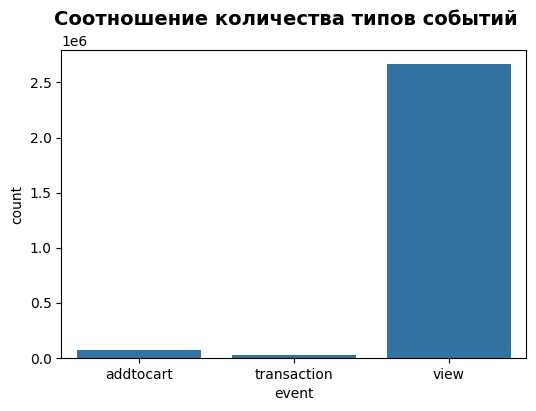

In [18]:
plt.figure(figsize=(6, 4))
event_countplot = sns.countplot(
    data=events,
    x='event')
plt.suptitle(
    'Соотношение количества типов событий',
    fontweight='bold',
    fontsize=14);

Признак transactionid содержит 99 % пропусков, это обусловлено тем, что количество выполненных транзакций равно 22457 из 2756101 записей. Подавляющее большинство записей являются только просмотром товара.

### Распределение признаков

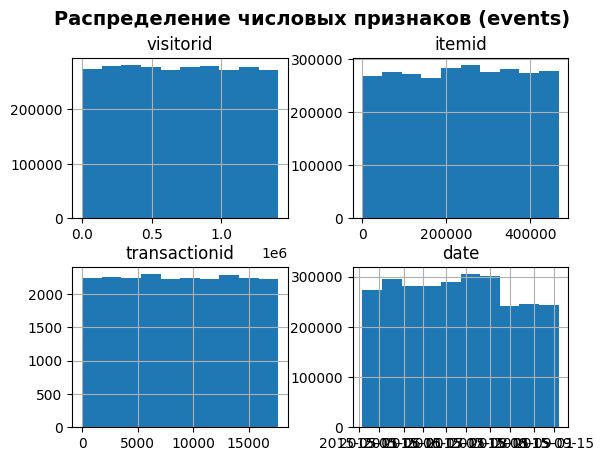

In [19]:
event_hist = events.hist();
plt.suptitle(
    'Распределение числовых признаков (events)',
    fontweight='bold',
    fontsize=14);

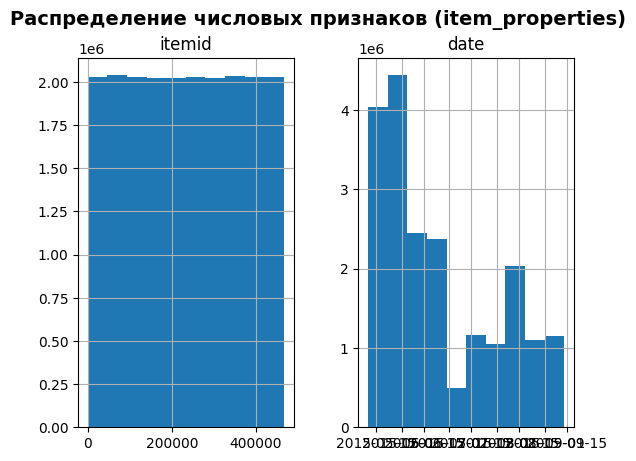

In [20]:
item_properties.hist()
plt.suptitle(
    'Распределение числовых признаков (item_properties)',
    fontweight='bold',
    fontsize=14);

### Проверим корреляцию

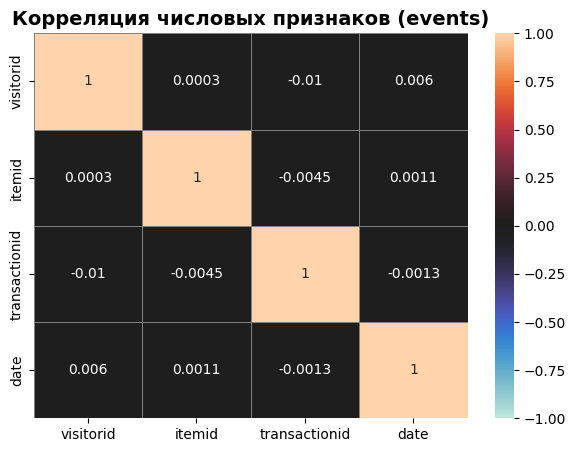

In [21]:
corr = events[events.describe().columns].corr().round(4)

plt.subplots(figsize=(7,5))
heatmap = sns.heatmap(
    corr,
    annot      = True,
    linewidths = 0.5,
    vmin       = -1,
    vmax       = 1,
    center     = 0,
    linecolor  = 'grey')
heatmap.set_title('Корреляция числовых признаков (events)', fontweight='bold', size=14);

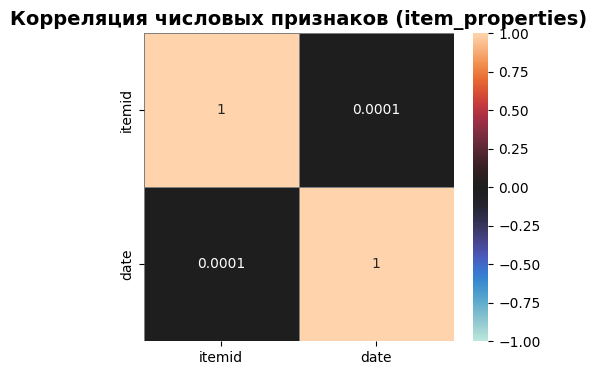

In [22]:
corr = item_properties[item_properties.describe().columns].corr().round(4)

plt.subplots(figsize=(5,4))
heatmap = sns.heatmap(
    corr,
    annot      = True,
    linewidths = 0.5,
    vmin       = -1,
    vmax       = 1,
    center     = 0,
    linecolor  = 'grey')
heatmap.set_title('Корреляция числовых признаков (item_properties)', fontweight='bold', size=14);

Данные имют нулевую корреляцию и никак не связаны между собой

### Поиск дубликатов

In [23]:
dupl_columns = list(events.columns)

mask = events.duplicated(subset=dupl_columns)
print(f'Число найденных дубликатов в events: {events[mask].shape[0]}')

# удалим дубликаты
events = events.drop_duplicates(keep='first')

Число найденных дубликатов в events: 460


In [24]:
dupl_columns = list(item_properties.columns)

mask = item_properties.duplicated(subset=dupl_columns)
item_properties_duplicates = item_properties[mask]
print(f'Число найденных дубликатов в item_properties: {item_properties_duplicates.shape[0]}')

Число найденных дубликатов в item_properties: 0


### Определение неинформативных признаков

In [25]:
ilif(events)

event: 96.68% одинаковых значений
date: 99.81% уникальных значений


In [26]:
ilif(item_properties)

В целом можно сделать вывод, что неинформативных признаков в датасете нет.

### Дерево категорий

Посмотрим на визуализацию дерева категорий

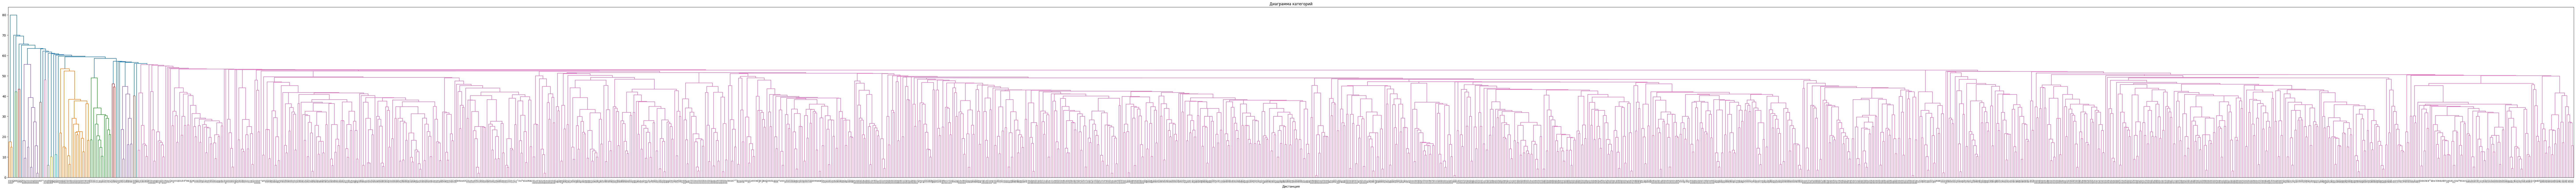

In [27]:
# Заполняем NaN значениями, чтобы избежать ошибок при построении дендрограммы
ct = category_tree.fillna(0)

# Создаем матрицу связей для построения дендрограммы
links = linkage(ct[['categoryid', 'parentid']], 'single')

# Строим дендрограмму
plt.figure(figsize=(150, 10))
dendrogram(links, labels=ct['categoryid'].tolist(), orientation='top', leaf_font_size=5)
plt.title('Диаграмма категорий')
plt.xlabel('Дистанция')
plt.show();

Как видно из графика, товары имеют обширную и достатоно подробную группировку по категориям.

### Самые популярные item-ы

Посмотрим на топ 50 самых популярных товаров, котрые просматривали, доавили в корзину и выполнили транзакцию.

In [28]:
# Разделим датасет по типу событий
events_view         = events[events['event'] == 'view']
events_addtocart    = events[events['event'] == 'addtocart']
events_transaction  = events[events['event'] == 'transaction']

In [29]:
# Рассчитаем количество событий для каждого айтема
item_popularity_view        = events_view.groupby('itemid')['event'].count().reset_index().rename(columns={'event': 'popularity_view'})
item_popularity_addtocart   = events_addtocart.groupby('itemid')['event'].count().reset_index().rename(columns={'event': 'popularity_addtocart'})
item_popularity_transaction = events_transaction.groupby('itemid')['event'].count().reset_index().rename(columns={'event': 'popularity_transaction'})

In [30]:
# Возьмем топ 50 популярных транзакций
df_view         = item_popularity_view.sort_values(by='popularity_view', ascending=False).head(50)
df_addtocart    = item_popularity_addtocart.sort_values(by='popularity_addtocart', ascending=False).head(50)
df_transaction  = item_popularity_transaction.sort_values(by='popularity_transaction', ascending=False).head(50)

In [31]:
# Объединение данных по столбцу itemid, оставив только те события, который имеют все три события
merged_df = pd.merge(df_view, df_addtocart, on='itemid')
# Добавим процент добавленных в корзину, по отношению к просмотрам
merged_df['popularity_addtocart_%'] = round((merged_df['popularity_addtocart'] / merged_df['popularity_view']) * 100, 2)

merged_df = pd.merge(merged_df, df_transaction, on='itemid')
# Добавим процент выполненных транзакций, по отношению к добавленным в корзину
merged_df['popularity_transaction_%'] = round((merged_df['popularity_transaction'] / merged_df['popularity_addtocart']) * 100, 2)

merged_df

,itemid,popularity_view,popularity_addtocart,popularity_addtocart_%,popularity_transaction,popularity_transaction_%
0,461686,2538,304,11.98,133,43.75
1,309778,1565,48,3.07,15,31.25
2,257040,1531,89,5.81,27,30.34
3,384302,1528,65,4.25,15,23.08
4,7943,1346,97,7.21,46,47.42
5,320130,1333,141,10.58,33,23.40
6,234255,1214,77,6.34,16,20.78
7,190000,1164,47,4.04,20,42.55
8,37029,1131,71,6.28,25,35.21
9,369447,1103,80,7.25,31,38.75


Можно сделать вывод, что товар с id **461686** является достаточно популярным, его больше всего просматривают, с 12% верятностью добавляют в корзину и после этого с 44% шансом совершают транзакцию.

Так же интересны товары с id **312728** и **445351**

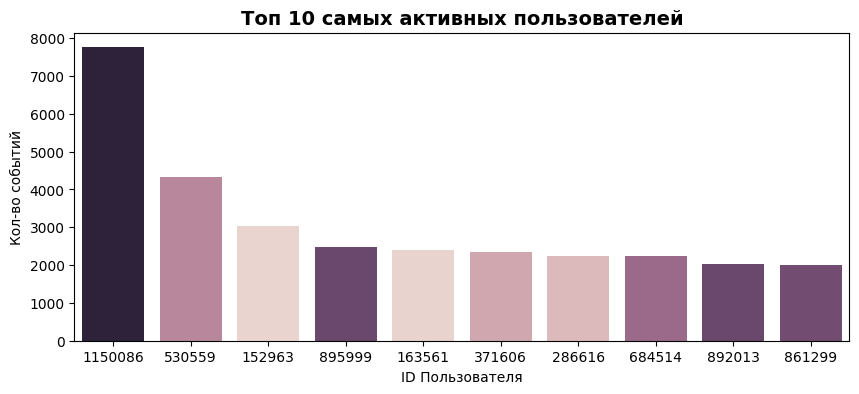

In [32]:
top_most_active_user = events['visitorid'].value_counts().head(10)
top_most_active_user = top_most_active_user.sort_values(ascending=False)

plt.figure(figsize=(10, 4))

sns.barplot(
    x     = top_most_active_user.index,
    y     = top_most_active_user.values,
    order = top_most_active_user.index,
    hue   = top_most_active_user.index,
    legend = False
)
plt.title('Топ 10 самых активных пользователей', fontweight='bold', fontsize=14)
plt.xlabel('ID Пользователя')
plt.ylabel('Кол-во событий')
plt.show();

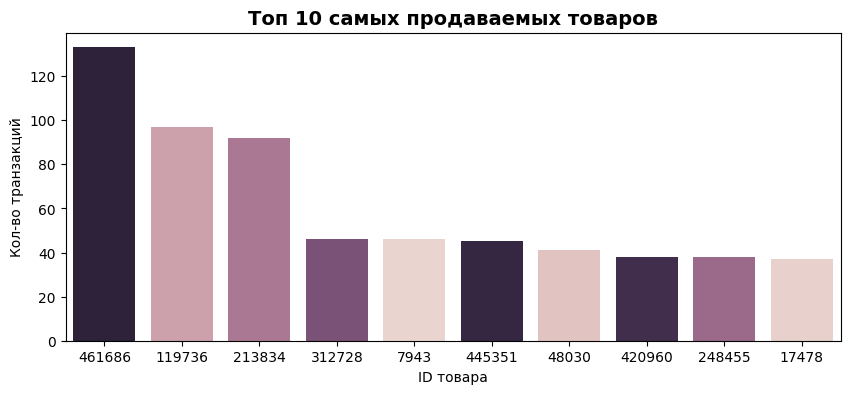

In [33]:
top_sold_items = events[events['event']=='transaction']['itemid'].value_counts().head(10)
top_sold_items = top_sold_items.sort_values(ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(
    x      = top_sold_items.index, 
    y      = top_sold_items.values, 
    order  = top_sold_items.index,
    hue    = top_sold_items.index,
    legend = False
)
plt.title('Топ 10 самых продаваемых товаров', fontweight='bold', fontsize=14)
plt.xlabel('ID товара')
plt.ylabel('Кол-во транзакций')
plt.show();

# Создание факторов для модели

## Генерация факторов, связанных с датой

In [34]:
# Извлеките признаки
events['hour']          = events['date'].dt.hour
events['month']         = events['date'].dt.month
events['day_of_week']   = events['date'].dt.dayofweek
events['is_weekend']    = events['date'].dt.weekday // 5  # 1 - выходной, 0 - будний день


# Определите праздничные дни
us_holidays = holidays.US(years=events['date'].dt.year.unique())
events['is_holiday'] = events['date'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

# Определите временной признак
events['time_of_day'] = pd.cut(events['date'].dt.hour,
                           bins=[0, 6, 12, 18, 24],
                           labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                           include_lowest=True)

# Выведите результат
events.head()

,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,is_holiday,time_of_day
0,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,0,Night
1,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,0,Night
2,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,0,Night
3,483717,view,253185,NaN,2015-06-02 05:12:35.914,5,6,1,0,0,Night
4,951259,view,367447,NaN,2015-06-02 05:02:17.106,5,6,1,0,0,Night


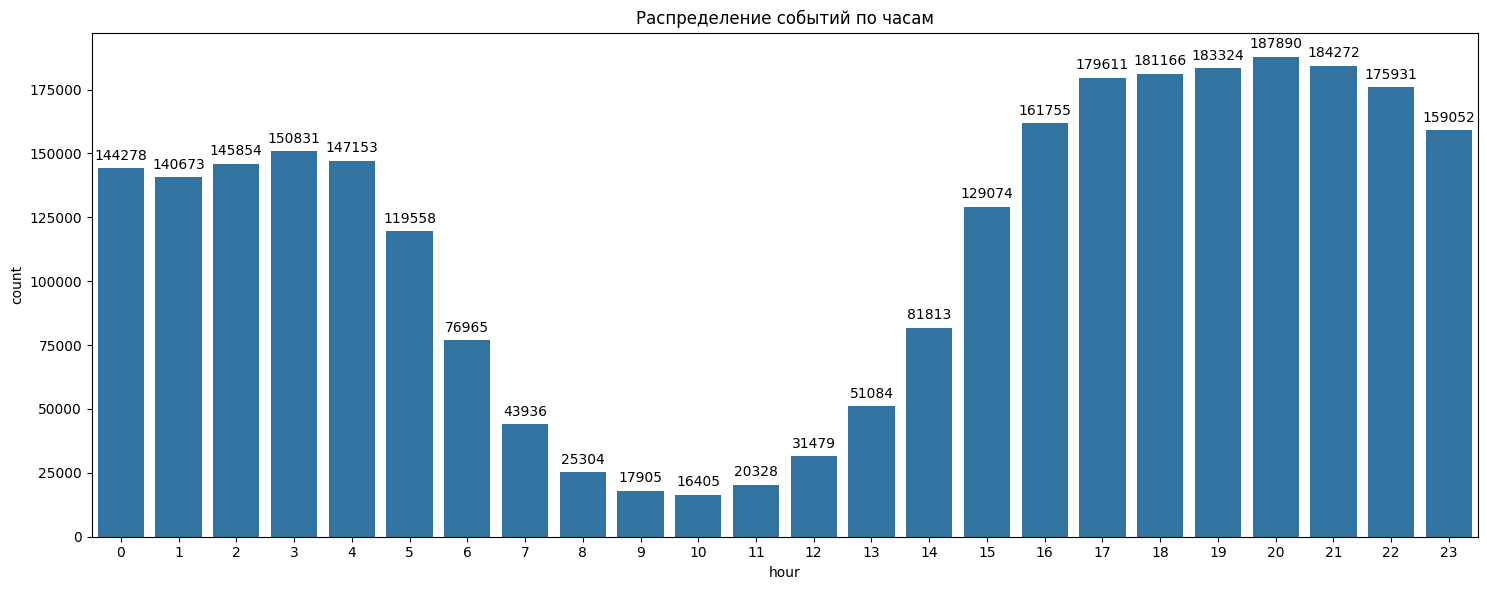

In [35]:
plt.figure(figsize=(15, 6))

countplot = sns.countplot(data=events, x='hour')
plt.title('Распределение событий по часам')
for p in countplot.patches:
    countplot.annotate(
        format(p.get_height(), '.0f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', 
        va = 'center', 
        xytext = (0, 9), 
        textcoords = 'offset points'
    )

plt.tight_layout()
plt.show();

## Генерация факторов, связанных с айтемами

In [36]:
mapping = {'view': 0, 'transaction': 1, 'addtocart': 1}
events['event'] = np.vectorize(mapping.get)(events['event'])

Генерация факторов, связанных с айтемами, используя матричную факторизацию с алгоритмом ALS

In [37]:
# Создание разреженной матрицы item-user
events['event_value'] = (events['event'] == 1).astype(int)
item_user_matrix = coo_matrix((events['event_value'], (events['itemid'], events['visitorid']))).tocsr()


# Инициализация ALS модели
als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50)

# Обучение модели ALS
als_model.fit(item_user_matrix)

# Получение факторов для айтемов
item_factors = als_model.item_factors

# Создание DataFrame с факторами айтемов
item_factors_df = pd.DataFrame(item_factors, index=range(1, item_factors.shape[0] + 1), columns=[f'item_factor_{i}' for i in range(item_factors.shape[1])])

# Добавление факторов айтемов к исходному датасету с айтемами
# items_with_factors = pd.merge(events, item_factors_df, left_on='itemid', right_index=True, how='left')
events = pd.merge(events, item_factors_df, left_on='itemid', right_index=True, how='left')

events.head(3)

  0%|          | 0/50 [00:00<?, ?it/s]

,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,is_holiday,...,item_factor_40,item_factor_41,item_factor_42,item_factor_43,item_factor_44,item_factor_45,item_factor_46,item_factor_47,item_factor_48,item_factor_49
0,257597,0,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,0,...,-1.030466e-12,2.571046e-12,5.143290e-13,-1.672001e-12,2.022305e-12,-2.248183e-12,-9.709937e-13,2.050757e-12,-8.732769e-13,2.945108e-13
1,992329,0,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,0,...,-1.225458e-12,2.733972e-12,4.261451e-13,-1.915036e-12,2.404233e-12,-2.374486e-12,-1.247882e-12,2.267736e-12,-1.032144e-12,3.385943e-13
2,111016,0,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,0,...,8.156991e-13,-2.364398e-12,-2.910297e-13,1.158544e-12,-1.899730e-12,2.172328e-12,6.648477e-13,-1.712408e-12,2.667049e-13,-5.208845e-13


## Генерация факторов айтем-юзер

Создадание факторов для айтемов и пользователей с использованием ALS. Мы будем использовать разреженную матрицу user-item, транспонированную относительно предыдущей матрицы.

In [38]:
# Создание разреженной матрицы user-item в формате CSR
user_item_matrix = coo_matrix((events['event_value'], (events['visitorid'], events['itemid']))).T.tocsr()

# Инициализация ALS модели для user-item матрицы
als_user_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50)

# Обучение модели ALS для user-item матрицы
als_user_model.fit(user_item_matrix)

# Получение факторов для пользователей
user_factors = als_user_model.user_factors

# Создание DataFrame с факторами пользователей
user_factors_df = pd.DataFrame(user_factors, index=range(1, user_factors.shape[0] + 1), columns=[f'user_factor_{i}' for i in range(user_factors.shape[1])])

# Добавление факторов пользователей к исходному датасету с айтемами
# items_with_user_factors = pd.merge(items_with_factors, user_factors_df, left_on='visitorid', right_index=True, how='left')

events = pd.merge(events, user_factors_df, left_on='visitorid', right_index=True, how='left')

events.head(3)

  0%|          | 0/50 [00:00<?, ?it/s]

,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,is_holiday,...,user_factor_40,user_factor_41,user_factor_42,user_factor_43,user_factor_44,user_factor_45,user_factor_46,user_factor_47,user_factor_48,user_factor_49
0,257597,0,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,992329,0,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,111016,0,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Валидационный датасет

Создадим валидационный датасет, разбив данные по времени. Для этого возьмем последние семь дней данных в качестве валидационного периода.

In [39]:
# Последние несколько дней данных
validation_period = events['date'].max() - pd.DateOffset(days=7)

# Разделим данные на тренировочный и валидационный датасеты
train_data      = events[events['date'] < validation_period]
validation_data = events[events['date'] >= validation_period]

print(f'Train data: {train_data.shape}')
print(f'Validation data: {validation_data.shape}')

Train data: (2640903, 112)
Validation data: (114738, 112)


### Объединим датасеты

In [40]:
merged_events = events.merge(item_properties, on=['itemid', 'date'], how='left')

merged_events = merged_events.merge(category_tree, left_on='property', right_on='categoryid', how='left')

merged_events.head(3)

,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,is_holiday,...,user_factor_44,user_factor_45,user_factor_46,user_factor_47,user_factor_48,user_factor_49,property,value,categoryid,parentid
0,257597,0,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,992329,0,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,111016,0,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [41]:
# Последние несколько дней данных
merged_validation_period = merged_events['date'].max() - pd.DateOffset(days=7)

# Разделим данные на тренировочный и валидационный датасеты
merged_train_data      = merged_events[merged_events['date'] < merged_validation_period]
merged_validation_data = merged_events[merged_events['date'] >= merged_validation_period]

print(f'Train data (merged): {merged_train_data.shape}')
print(f'Validation data (merged): {merged_validation_data.shape}')

Train data (merged): (2640903, 116)
Validation data (merged): (114738, 116)
